## **1. Import**

In [10]:
from tqdm.notebook import tqdm

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [11]:
pl.Config.set_tbl_cols(100)
pl.Config.set_tbl_rows(30)

polars.config.Config

## **2. Load Data**

In [12]:
data_path = '../../data/opt_data/Group_4_14.parquet'

df = pl.read_parquet(data_path)

# 카자흐스탄 시간 적용 해야함

df.head()

event_time_index,event_type_index,product_id_index,price,user_id_index,user_session_index,category_1_id,category_2_id,category_3_id,category_4_id,category_5_id,brand_id
u32,u8,u32,f32,u32,u32,u8,u16,u16,u16,u8,u16
1569888268,1,39192,74.620003,2390689,72616521,14,139,271,0,0,3740
1569888336,1,202044,64.220001,419815,60898410,14,138,264,0,0,4291
1569888396,1,37383,21.85,3655553,13919984,14,136,253,0,0,6325
1569888899,1,48348,20.57,4160807,31914114,14,139,282,0,0,1183
1569896249,1,93394,372.730011,4160904,66085779,14,137,258,0,0,2190


## **3. 중복행, 결측치, 이상치 파악**

### 3.1 중복행

In [13]:
columns = ['user_id_index', 'user_session_index', 'event_time_index', 'product_id_index']
df_grouped = df.group_by(columns).agg(pl.len())

# 각 열의 조합으로 그룹화하고 count 값이 1보다 큰 그룹을 선택
dup_df = df.group_by(columns).agg(
    pl.len().alias('count')
).filter(pl.col('count') > 1)

# 중복된 그룹을 원본 데이터프레임에서 필터링하여 출력
result = df.join(dup_df.select(columns), on=columns)

result

event_time_index,event_type_index,product_id_index,price,user_id_index,user_session_index,category_1_id,category_2_id,category_3_id,category_4_id,category_5_id,brand_id
u32,u8,u32,f32,u32,u32,u8,u16,u16,u16,u8,u16
1570008957,1,93326,179.669998,4145263,29069154,14,137,258,0,0,2190
1570008957,1,93326,179.669998,4145263,29069154,14,137,258,0,0,2190
1570027512,1,32684,199.229996,4240676,32683539,14,136,257,174,0,4202
1570027512,1,32684,199.229996,4240676,32683539,14,136,257,174,0,4202
1570033216,2,206666,332.049988,2455329,13471237,14,134,243,0,0,2411
1570033216,2,206666,332.049988,2455329,13471237,14,134,243,0,0,2411
1570036579,1,93354,178.639999,4247970,53219418,14,137,258,0,0,769
1570036579,1,93354,178.639999,4247970,53219418,14,137,258,0,0,769
1570036579,1,93354,178.639999,4247970,53219418,14,137,258,0,0,769


In [14]:
# 각 사용자별로 동일한 product_id_index의 개수와 event_type_index 집계
user_product_stats = result.group_by(['user_id_index', 'product_id_index']).agg([
    pl.len().alias('item_count'),
    pl.col('event_type_index')
])

# 그룹화된 결과를 user_id_index와 product_id_index로 정렬
user_product_stats = user_product_stats.sort(['user_id_index', 'product_id_index'])

user_product_stats

user_id_index,product_id_index,item_count,event_type_index
u32,u32,u32,list[u8]
588,93413,2,"[2, 2]"
4281,46157,4,"[1, 2, … 2]"
4377,46852,3,"[2, 2, 1]"
4451,45188,2,"[1, 1]"
6686,32094,2,"[1, 1]"
8118,34860,2,"[1, 1]"
8118,34899,2,"[1, 1]"
8118,48055,2,"[1, 1]"
8118,48057,2,"[1, 1]"


### 3.2 결측치

In [15]:
df.null_count()

event_time_index,event_type_index,product_id_index,price,user_id_index,user_session_index,category_1_id,category_2_id,category_3_id,category_4_id,category_5_id,brand_id
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,17,0,0,0,0,0,0


In [16]:
# null 값을 포함한 user_session_index 행 필터링
null_df = df.filter(
    pl.col('user_session_index').is_null()
)

# 필터링된 결과를 user_id_index로 정렬
null_df = null_df.sort('user_id_index')

null_df

event_time_index,event_type_index,product_id_index,price,user_id_index,user_session_index,category_1_id,category_2_id,category_3_id,category_4_id,category_5_id,brand_id
u32,u8,u32,f32,u32,u32,u8,u16,u16,u16,u8,u16
1585460620,1,34976,50.189999,580972,null,14,139,269,0,0,2718
1573313547,2,108949,37.77,2680679,null,14,135,252,0,0,6255
1588067634,2,268246,47.490002,2872168,null,14,134,246,162,0,6866
1586369022,1,45715,11.97,3052626,null,14,139,276,0,0,7473
1578823030,2,45004,45.790001,5466543,null,14,139,270,177,0,4882
1577421351,2,46338,5.77,8846546,null,14,139,276,0,0,1789
1579537533,2,49317,21.879999,10428702,null,14,139,282,0,0,4161
1579599623,2,45704,11.33,10463664,null,14,139,276,0,0,4745
1585756102,1,46102,10.19,10823039,null,14,139,276,0,0,1789


## **4. `user_id_index`, `user_session`, `product_id`**

In [17]:
unique_counts = pl.DataFrame({
    "user_id_index_count": [df['user_id_index'].unique().count()],
    "user_session_index_count": [df['user_session_index'].unique().count()],
    "product_id_index_count": [df['product_id_index'].unique().count()]
    })

unique_counts

user_id_index_count,user_session_index_count,product_id_index_count
i64,i64,i64
1969627,4666538,23033


## **5. `price` 분포**

In [18]:
df['price'].describe()

statistic,value
str,f64
"""count""",1.3736649e7
"""null_count""",0.0
"""mean""",98.455673
"""std""",142.561111
"""min""",0.0
"""25%""",20.85
"""50%""",53.77
"""75%""",113.769997
"""max""",2574.070068


### 가격이 0인 제품 수

In [19]:
# 가격이 0인 데이터 필터링
zero_price_products = df.filter(pl.col('price') == 0)

# 결과 출력
zero_price_products

event_time_index,event_type_index,product_id_index,price,user_id_index,user_session_index,category_1_id,category_2_id,category_3_id,category_4_id,category_5_id,brand_id
u32,u8,u32,f32,u32,u32,u8,u16,u16,u16,u8,u16
1569896551,1,31092,0.0,4161010,68481331,14,136,257,174,0,676
1569897748,1,44941,0.0,3523504,65812852,14,139,270,177,0,3400
1569898635,1,45383,0.0,2790794,9949288,14,139,270,177,0,4655
1569902239,1,204747,0.0,4164058,32972955,14,136,257,173,0,2138
1569904230,1,40743,0.0,3948232,67239322,14,139,279,0,0,635
1569905944,1,30280,0.0,4166118,40691791,14,136,254,172,0,2568
1569905947,1,30280,0.0,4166118,40691791,14,136,254,172,0,2568
1569905950,1,30280,0.0,4166118,40691791,14,136,254,172,0,2568
1569908519,1,47607,0.0,2206106,57894590,14,139,270,177,0,4768


### 가격이 0인 제품 구매 수

- 카테고리 14에는 없음

In [20]:
# 가격이 0이고 event_type_index가 3인 데이터 필터링
zero_price_event_type_3 = df.filter(
    (pl.col('price') == 0) & (pl.col('event_type_index') == 3)
)

# product_id별로 해당 데이터의 개수 계산
zero_price_event_type_3_counts = zero_price_event_type_3.group_by('product_id_index').agg(
    pl.count('event_type_index').alias('count')
)

# 결과 출력
zero_price_event_type_3_counts

product_id_index,count
u32,u32


### 이벤트 상위 50개 제품 시간별 가격 그래프

- 45004 제품은 할인을 어떻게 봐야할지?

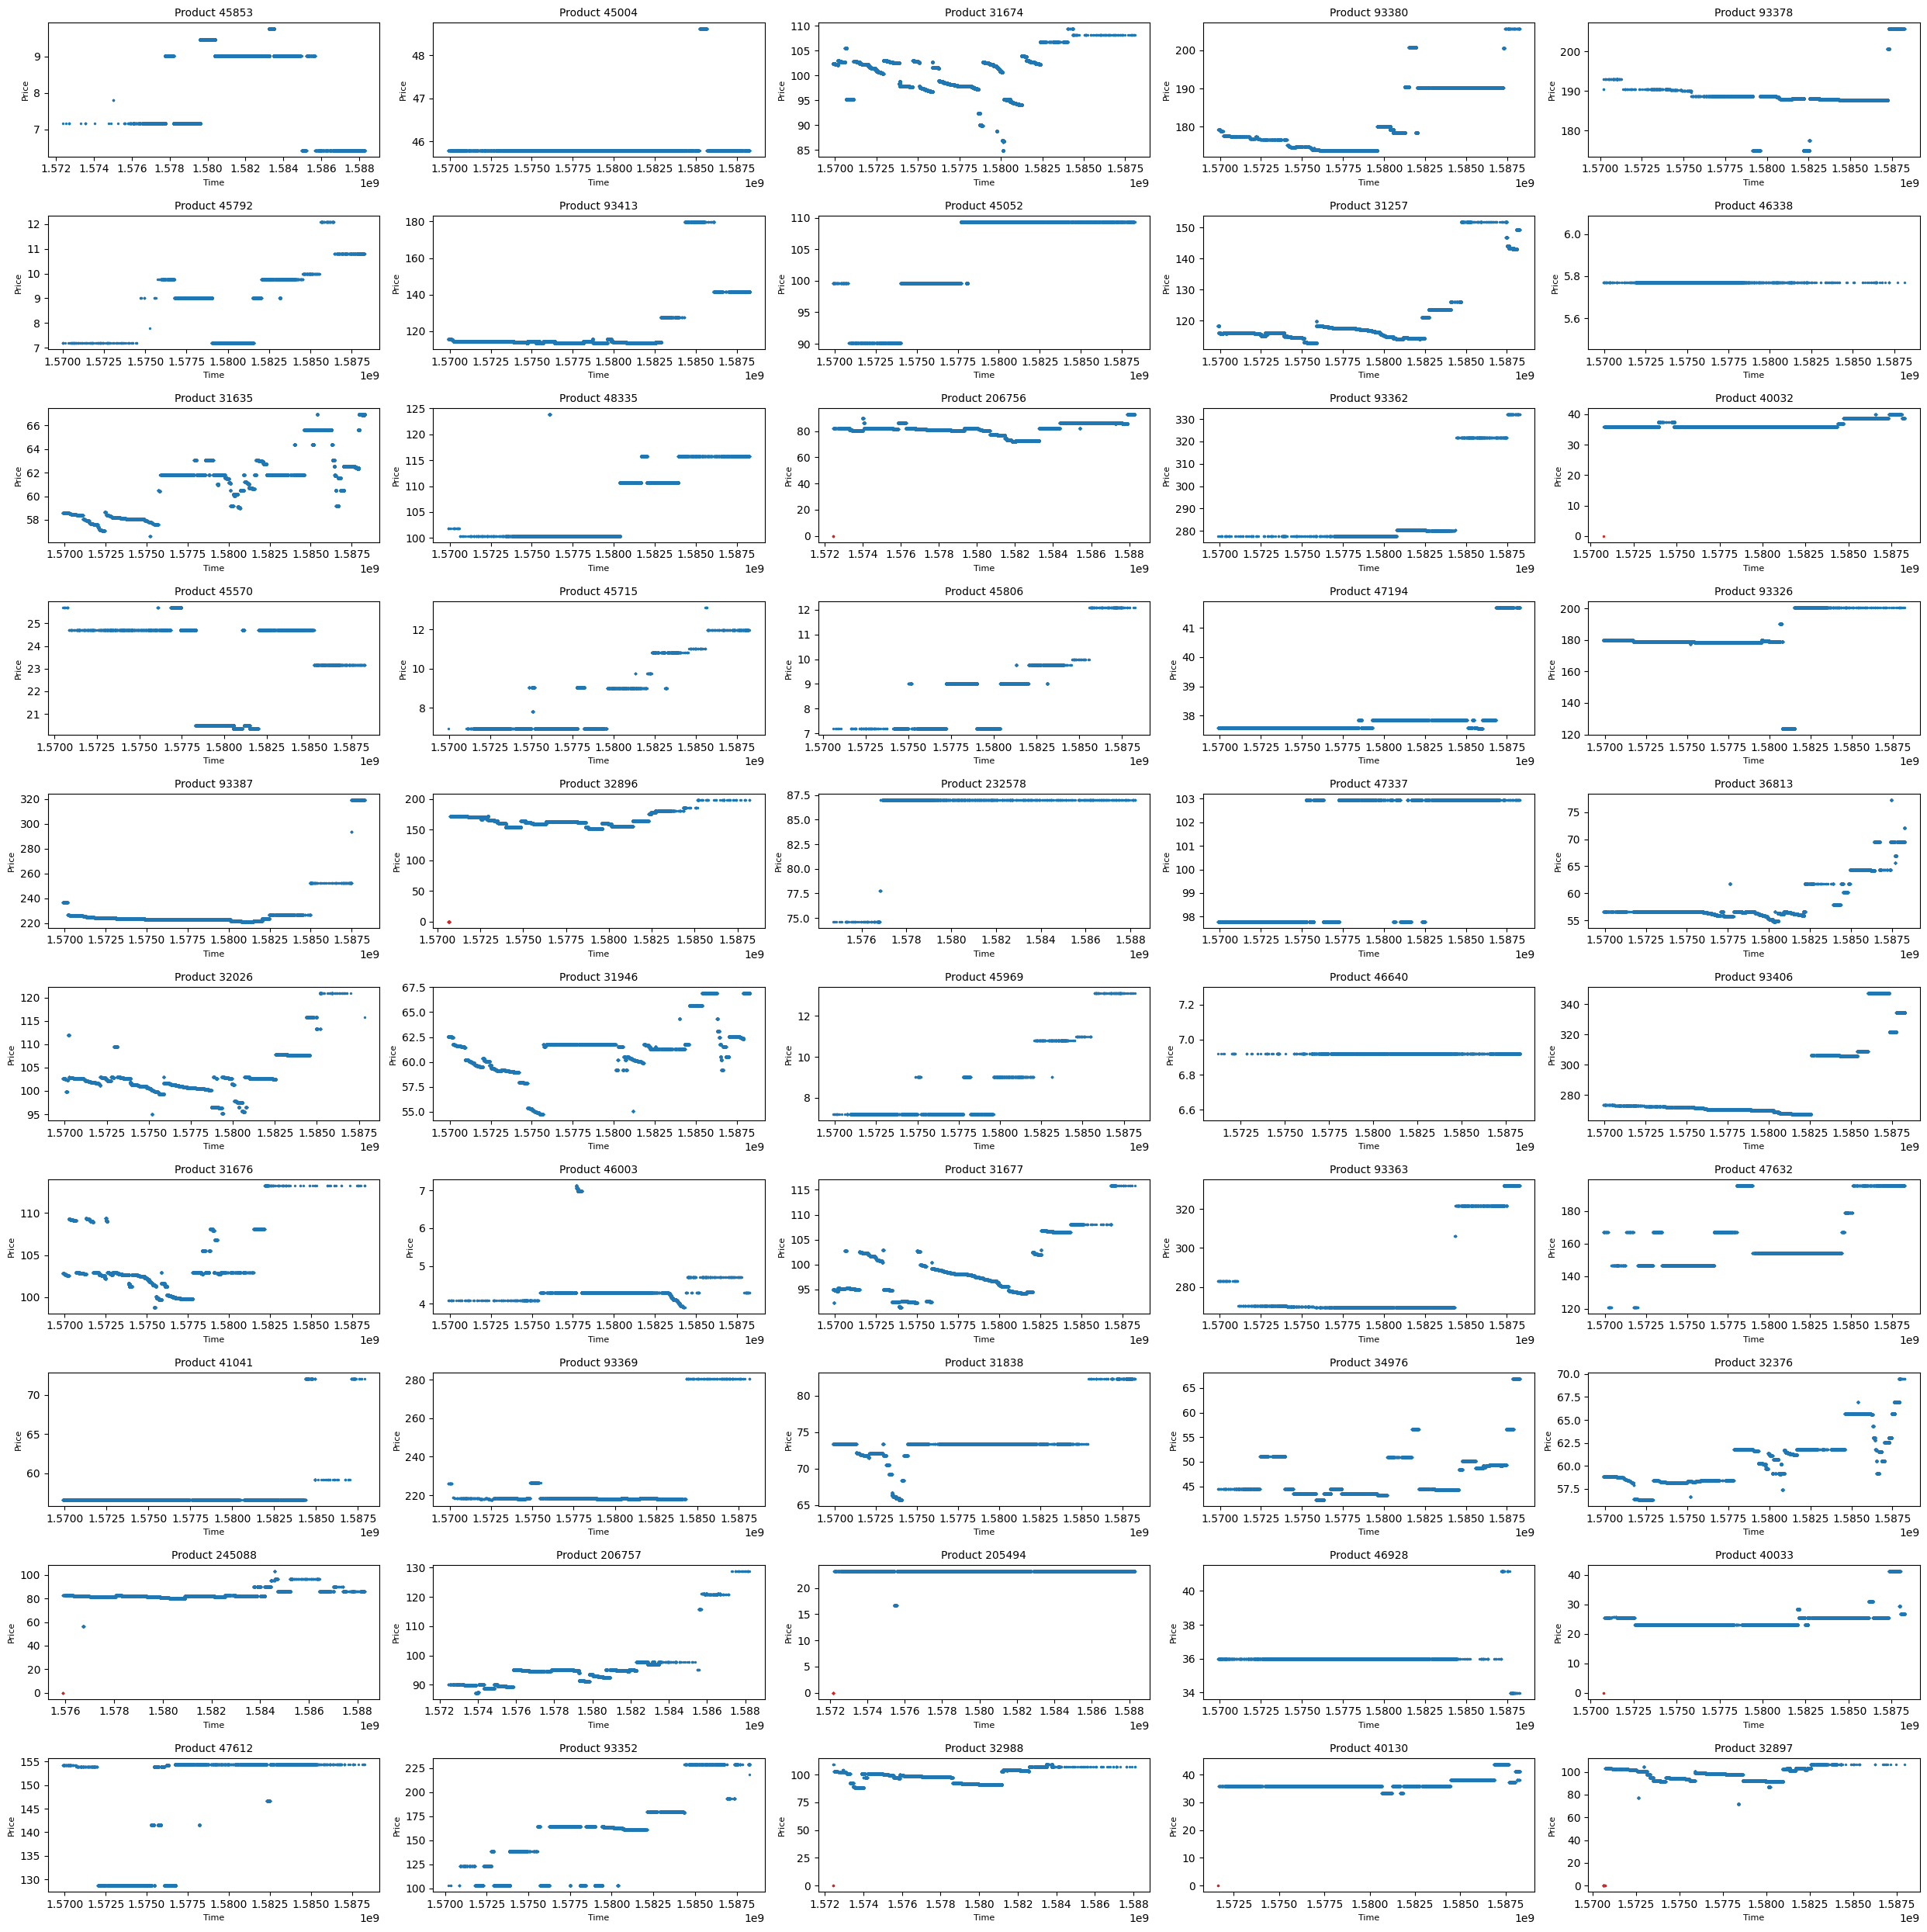

In [21]:
# 제품 빈도 계산
product_counts = df.group_by('product_id_index').agg(
    pl.count('product_id_index').alias('count')
)

# 상위 50개 제품 선택
top_50_products = product_counts.sort('count', descending=True).head(50)

# 상위 50개 제품의 데이터를 필터링
filtered_df = df.filter(pl.col('product_id_index').is_in(top_50_products['product_id_index']))

# 플롯 설정
fig, axes = plt.subplots(10, 5, figsize=(25, 25))
axes = axes.flatten()

# 각 상위 50개 제품의 그래프 그리기
for i, product_id in enumerate(top_50_products['product_id_index']):
    product_data = filtered_df.filter(pl.col('product_id_index') == product_id).sort('event_time_index')
    
    ax = axes[i]
    
    # 가격이 0이 아닌 데이터는 파란색으로 플롯
    non_zero_data = product_data.filter(pl.col('price') != 0)
    ax.scatter(non_zero_data['event_time_index'], non_zero_data['price'], color='tab:blue', s=2, marker='o')
    
    # 가격이 0인 데이터는 빨간색으로 산점도
    zero_data = product_data.filter(pl.col('price') == 0)
    ax.scatter(zero_data['event_time_index'], zero_data['price'], color='tab:red', s=2, marker='o')
    
    ax.set_title(f"Product {product_id}", fontsize=10)
    ax.set_xlabel('Time', fontsize=8)
    ax.set_ylabel('Price', fontsize=8)

plt.tight_layout()
plt.show()

### 이벤트 상위 50개 제품 시간별 구매 가격 그래프

- 이벤트 상위 50개 제품 중 구매를 하나도 안한 제품이나 구매 횟수가 매우 적은 제품 존재

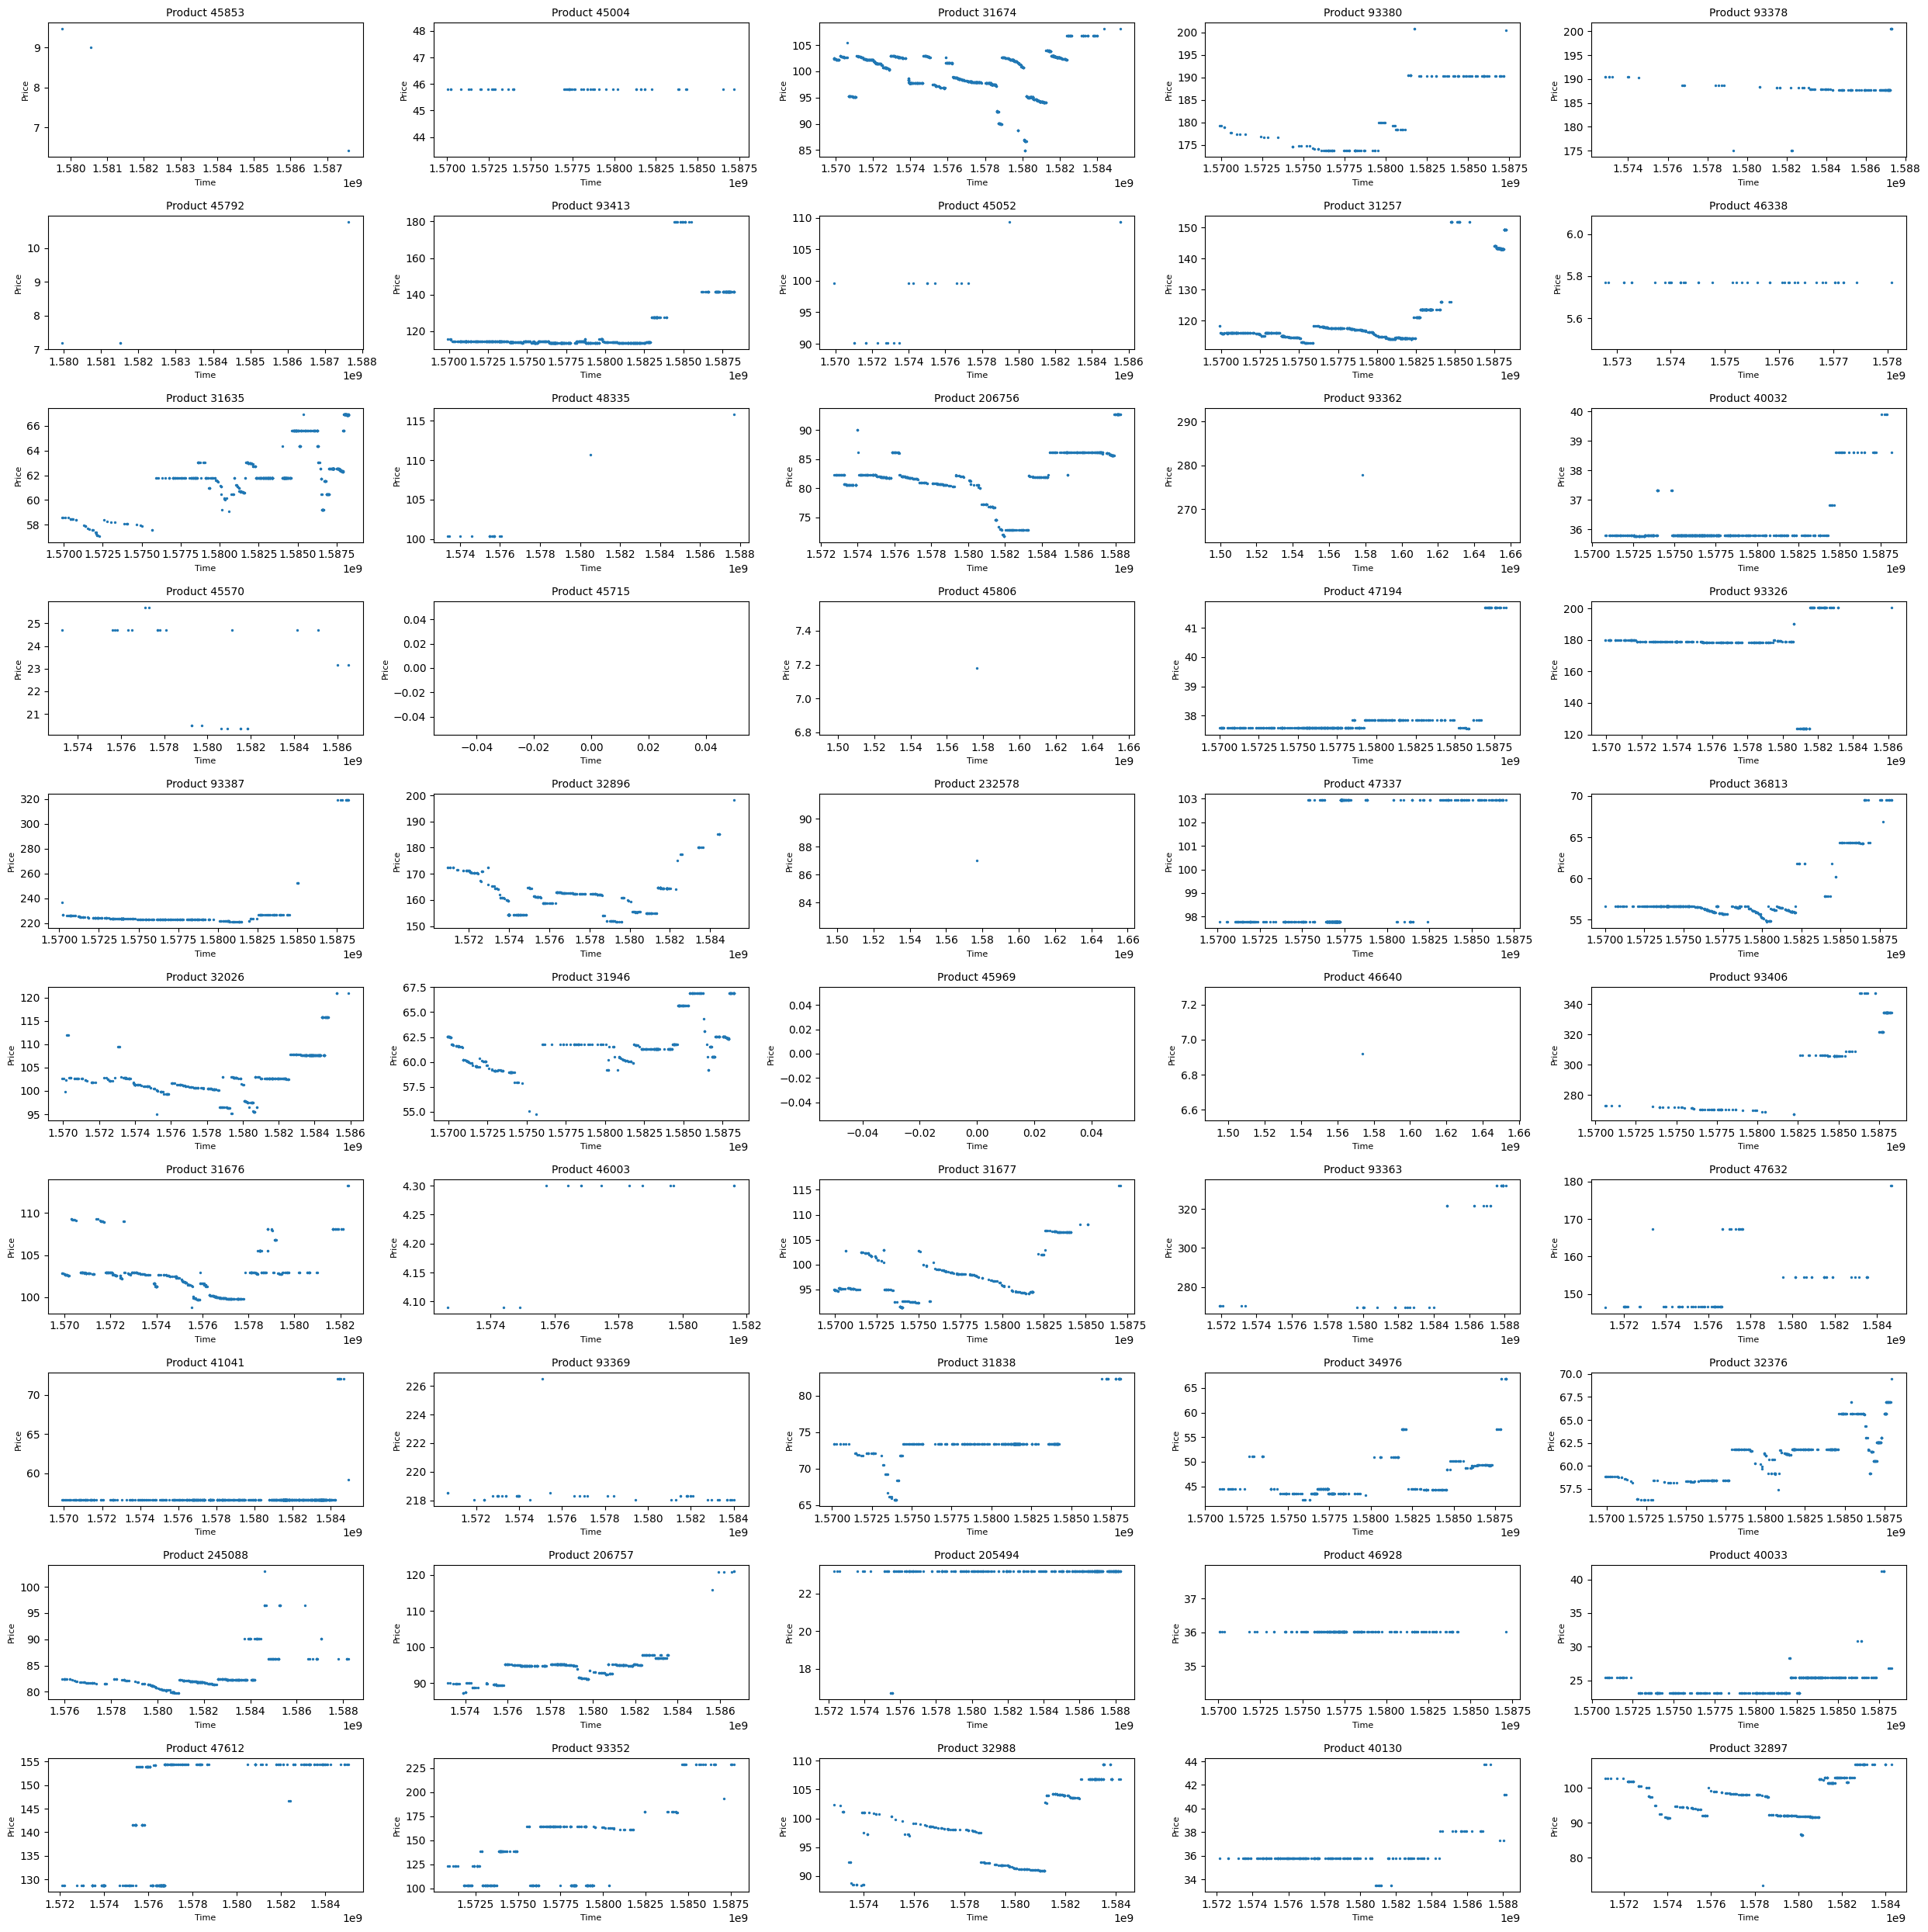

In [22]:
# 제품 빈도 계산
product_counts = df.group_by('product_id_index').agg(
    pl.count('product_id_index').alias('count')
)

# 상위 50개 제품 선택
top_50_products = product_counts.sort('count', descending=True).head(50)

# 상위 50개 제품 중 event_type_index가 3인 데이터 필터링
filtered_df = df.filter(
    (pl.col('product_id_index').is_in(top_50_products['product_id_index'])) & 
    (pl.col('event_type_index') == 3)
)

# 플롯 설정
fig, axes = plt.subplots(10, 5, figsize=(25, 25))
axes = axes.flatten()

# 각 상위 50개 제품의 그래프 그리기
for i, product_id in enumerate(top_50_products['product_id_index']):
    product_data = filtered_df.filter(pl.col('product_id_index') == product_id).sort('event_time_index')
    
    ax = axes[i]
    
    # 가격이 0이 아닌 데이터는 파란색으로 산점도
    non_zero_data = product_data.filter(pl.col('price') != 0)
    ax.scatter(non_zero_data['event_time_index'], non_zero_data['price'], color='tab:blue', s=2, marker='o')
    
    # 가격이 0인 데이터는 빨간색으로 산점도
    zero_data = product_data.filter(pl.col('price') == 0)
    ax.scatter(zero_data['event_time_index'], zero_data['price'], color='tab:red', s=2, marker='o')
    
    ax.set_title(f"Product {product_id}", fontsize=10)
    ax.set_xlabel('Time', fontsize=8)
    ax.set_ylabel('Price', fontsize=8)

plt.tight_layout()
plt.show()

### 구매 상위 50개 제품 시간별 가격 그래프

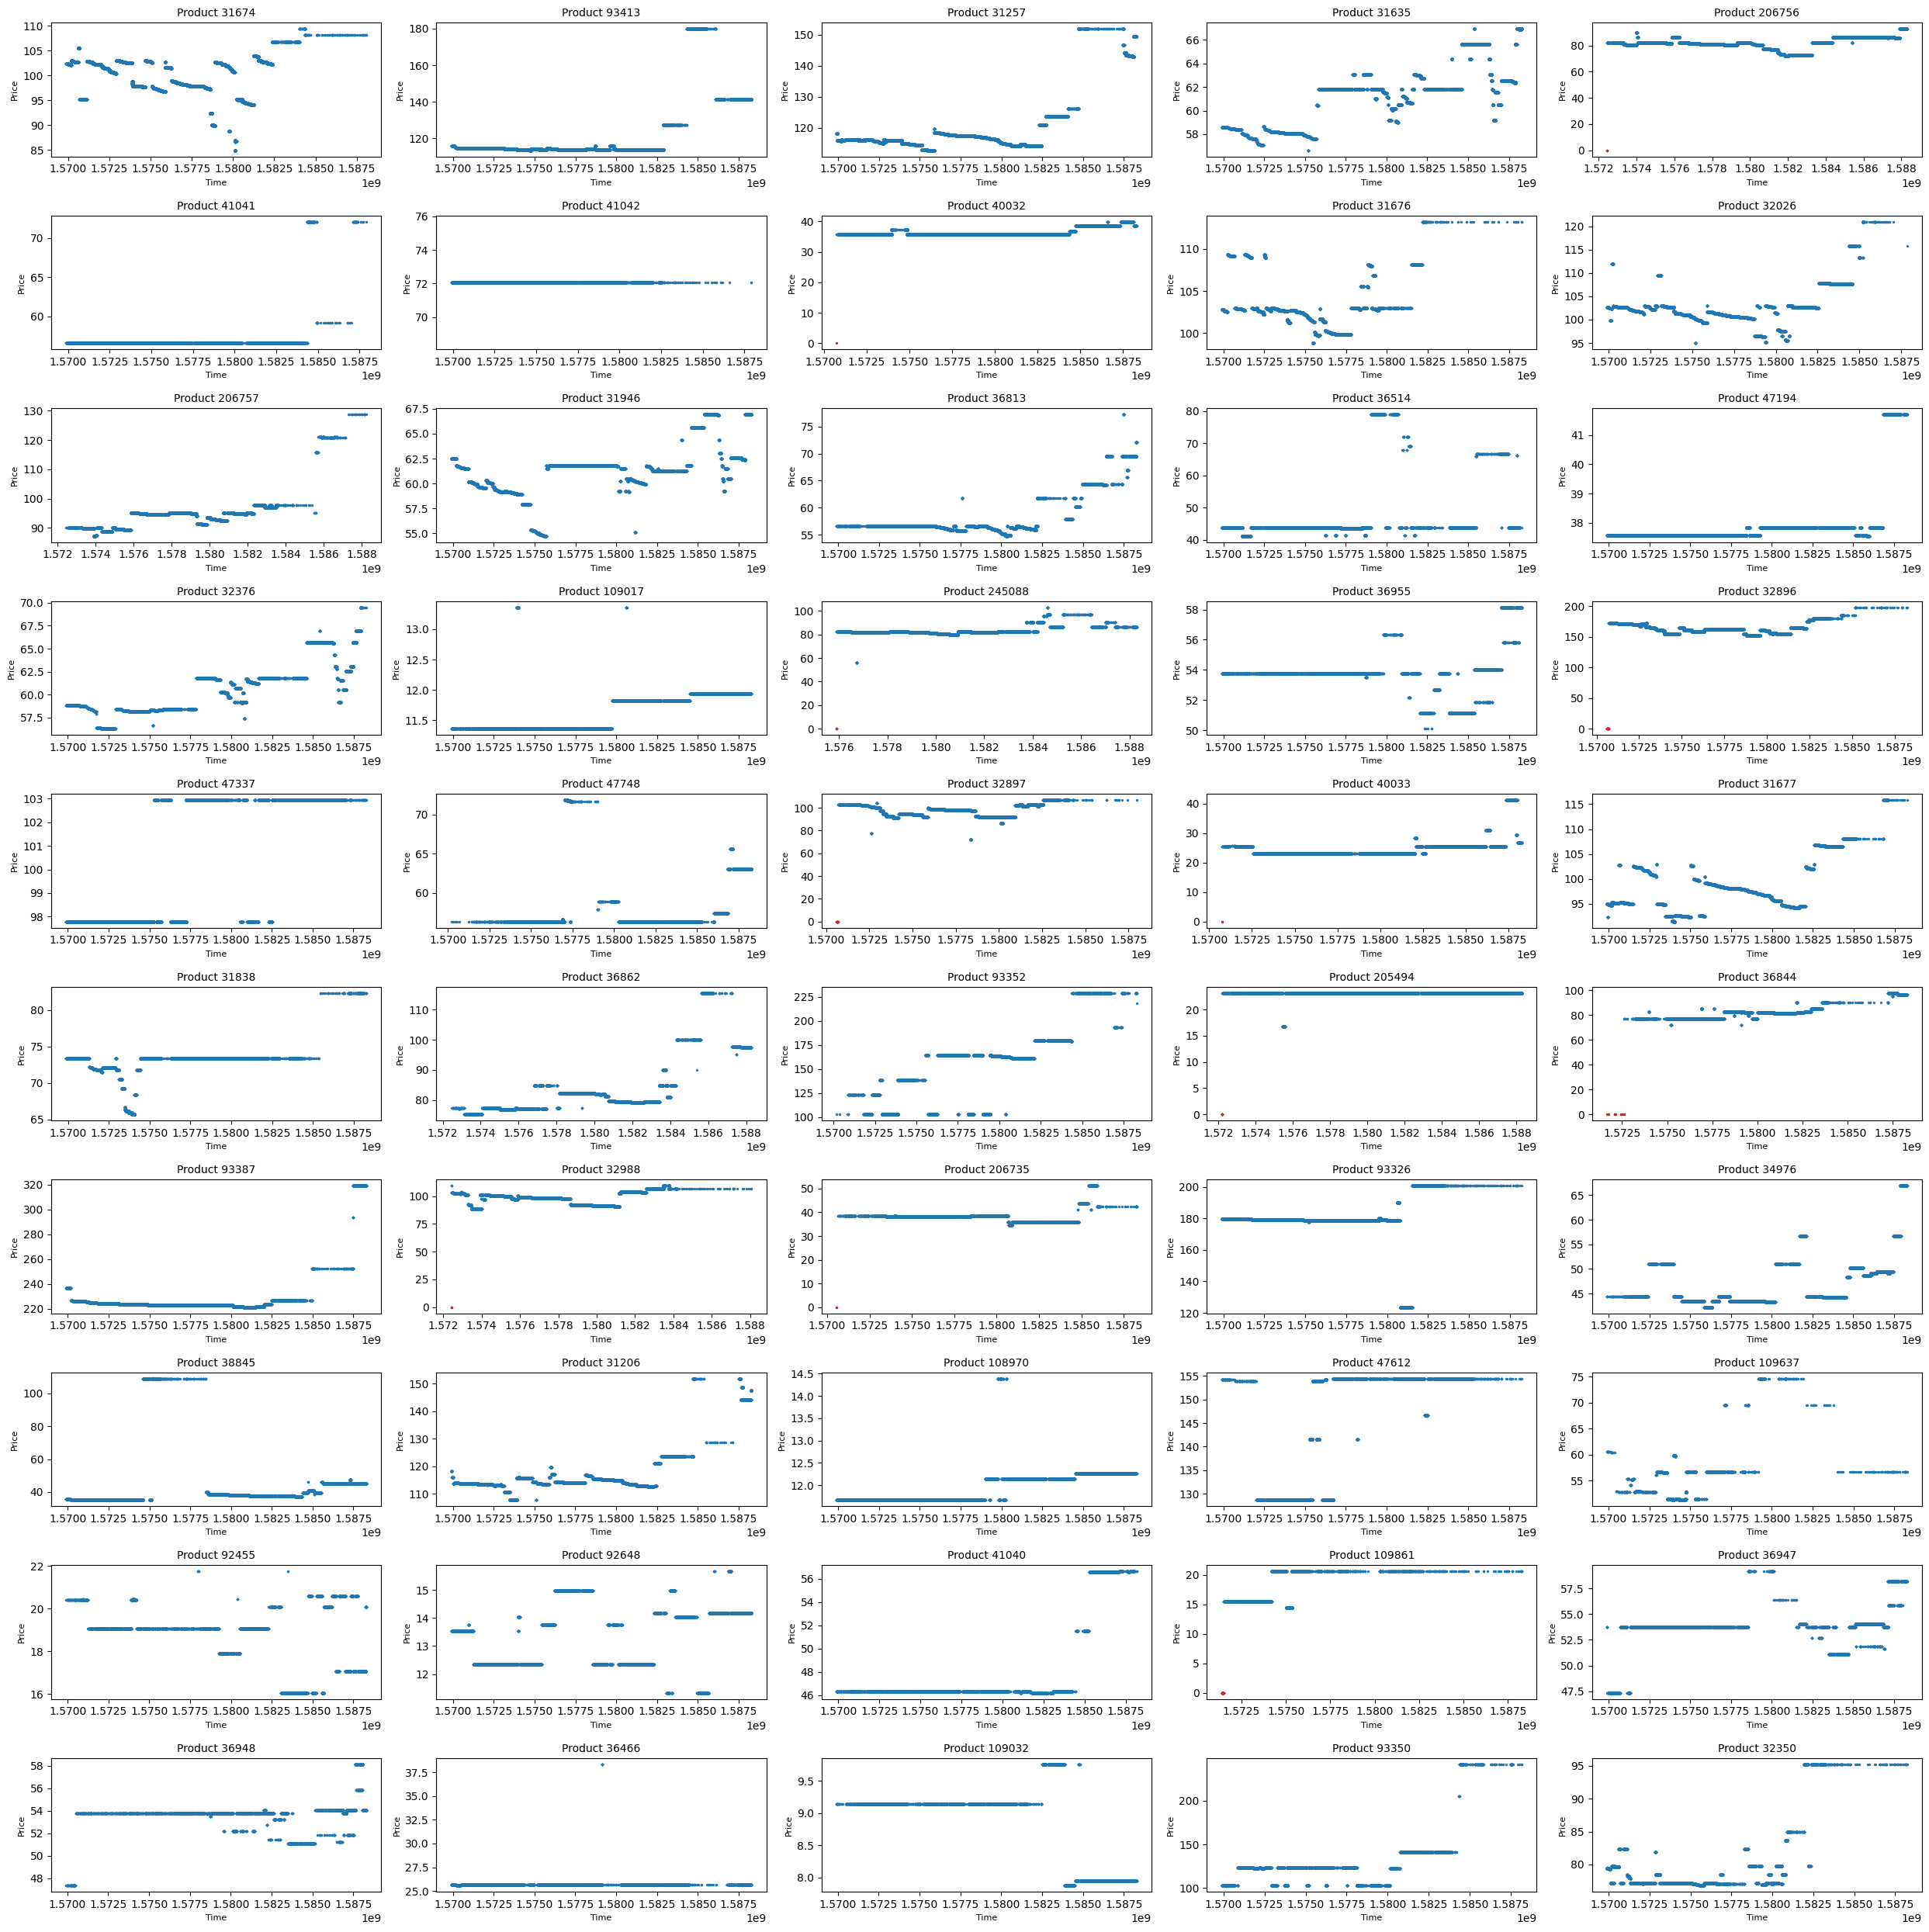

In [23]:
# event_type_index가 3인 데이터 필터링
event_type_3_df = df.filter(pl.col('event_type_index') == 3)

# product_id별로 event_type_index가 3인 개수 계산
event_type_3_counts = event_type_3_df.group_by('product_id_index').agg(
    pl.count('event_type_index').alias('count')
)

# 상위 50개 제품 선택
top_50_products = event_type_3_counts.sort('count', descending=True).head(50)

# 상위 50개 제품의 데이터를 필터링
filtered_df = df.filter(pl.col('product_id_index').is_in(top_50_products['product_id_index']))

# 플롯 설정
fig, axes = plt.subplots(10, 5, figsize=(25, 25))
axes = axes.flatten()

# 각 상위 50개 제품의 그래프 그리기
for i, product_id in enumerate(top_50_products['product_id_index']):
    product_data = filtered_df.filter(pl.col('product_id_index') == product_id).sort('event_time_index')
    
    ax = axes[i]
    
    # 가격이 0이 아닌 데이터는 파란색으로 플롯
    non_zero_data = product_data.filter(pl.col('price') != 0)
    ax.scatter(non_zero_data['event_time_index'], non_zero_data['price'], color='tab:blue', s=2, marker='o')
    
    # 가격이 0인 데이터는 빨간색으로 산점도
    zero_data = product_data.filter(pl.col('price') == 0)
    ax.scatter(zero_data['event_time_index'], zero_data['price'], color='tab:red', s=2, marker='o')
    
    ax.set_title(f"Product {product_id}", fontsize=10)
    ax.set_xlabel('Time', fontsize=8)
    ax.set_ylabel('Price', fontsize=8)

plt.tight_layout()
plt.show()

## **6. `event_type_index` 파악**

### 구매 상위 25개 제품의 구매 수

In [24]:
# 전체 product_id 목록 가져오기
all_product_ids = df.select('product_id_index').unique()

# event_type_index가 3인 데이터 필터링
filtered_df = df.filter(pl.col('event_type_index') == 3)

# product_id별로 event_type_index가 3인 개수 계산
event_type_3_counts = filtered_df.group_by('product_id_index').agg(
    pl.count('event_type_index').alias('count')
)

# 전체 product_id에 join하여 없는 경우 0으로 설정
event_type_3_counts = all_product_ids.join(event_type_3_counts, on='product_id_index', how='left').fill_null(0)

# 내림차순(상위) 25개 선택
top_25 = event_type_3_counts.sort('count', descending=True).head(25)

top_25

product_id_index,count
u32,u32
31674,1260
93413,1009
31257,973
31635,710
206756,661
41041,645
41042,602
40032,595
31676,517


### 구매 상위 25개 제품에 대한 구매수와 가격

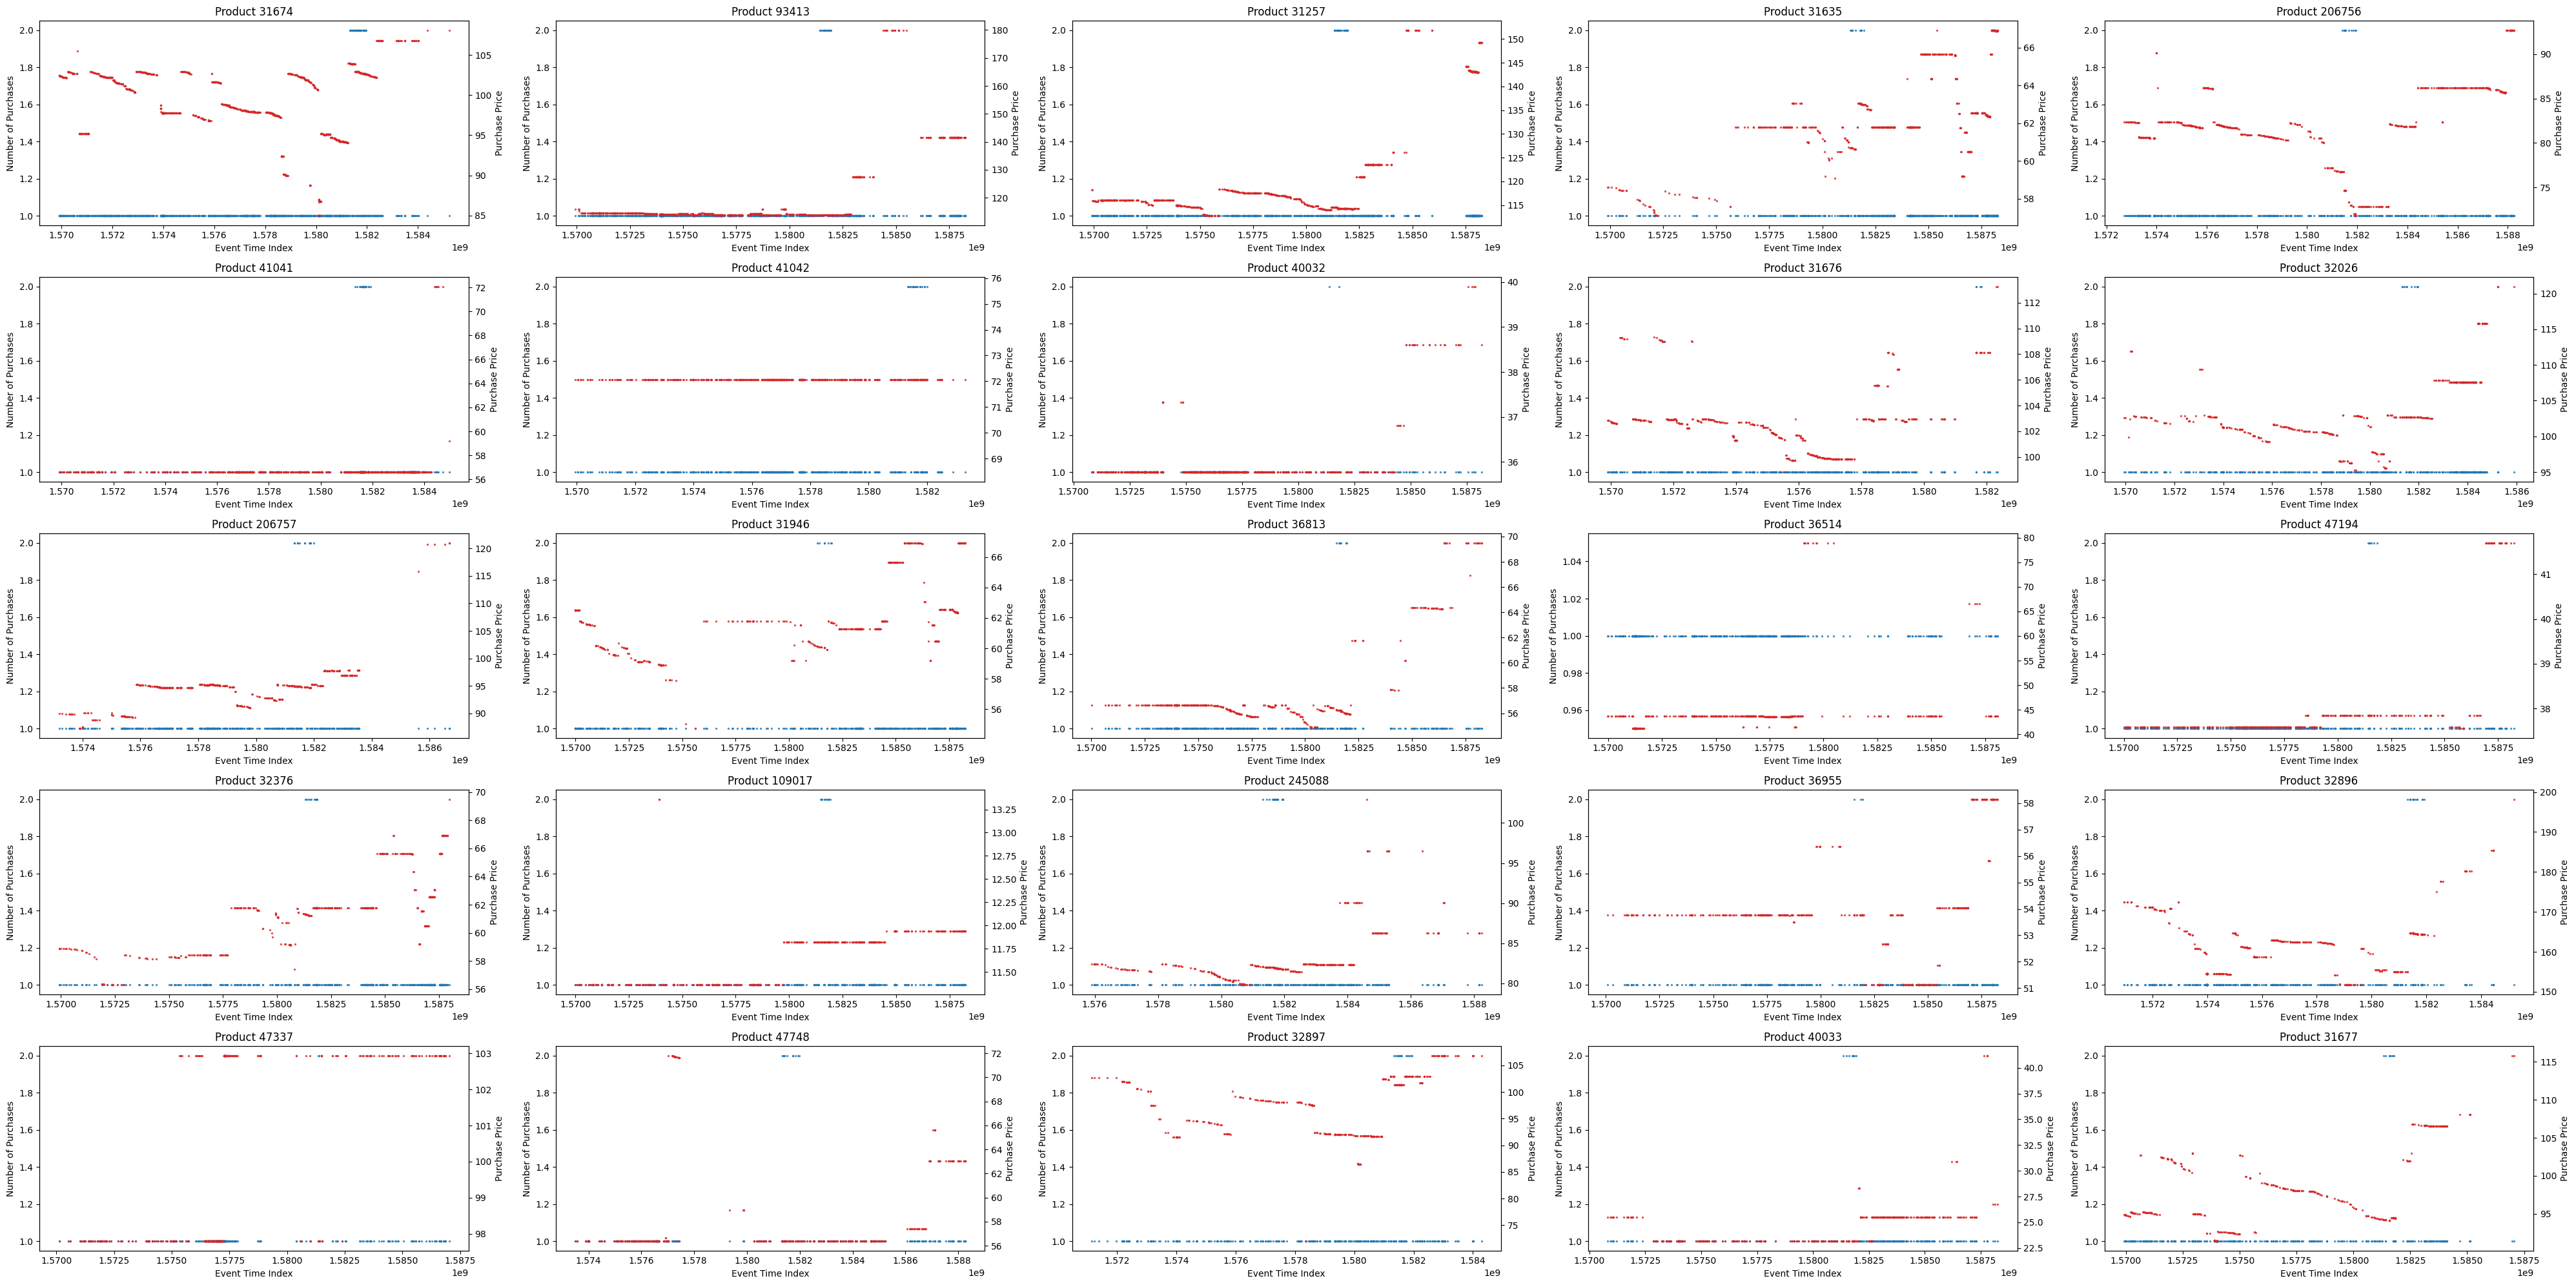

In [25]:
# 5x5 서브플롯 생성
fig, axes = plt.subplots(5, 5, figsize=(40, 20))
axes = axes.flatten()  # 2D 배열을 1D로 펼치기

# top_25의 각 product_id_index에 대해 그래프 그리기
for idx, row in enumerate(top_25.iter_rows(named=True)):
    product_id = row['product_id_index']

    # 필터링하여 필요한 데이터만 추출
    filtered_df = df.filter(
        (pl.col('product_id_index') == product_id) & (pl.col('event_type_index') == 3)
    )

    # event_time_index별로 구매 수를 집계
    purchase_counts = (
        filtered_df
        .group_by('event_time_index')
        .agg(pl.len().alias('count'))
        .sort('event_time_index')
    )

    # 현재 서브플롯 선택
    ax1 = axes[idx]

    # 왼쪽 Y축: 구매 수
    ax1.scatter(purchase_counts['event_time_index'], purchase_counts['count'], s=2, label='Number of Purchases', alpha=0.7, color='tab:blue')
    ax1.set_xlabel('Event Time Index')
    ax1.set_ylabel('Number of Purchases')

    # 오른쪽 Y축: 구매 가격
    ax2 = ax1.twinx()
    ax2.scatter(filtered_df['event_time_index'], filtered_df['price'], s=2, label='Purchase Price', alpha=0.7, color='tab:red')
    ax2.set_ylabel('Purchase Price')

    # 그래프 제목 설정
    ax1.set_title(f'Product {product_id}')

# 레이아웃 조정
plt.tight_layout()
plt.show()

### 구매가 일어난 제품 수 파악

In [26]:
event_type_3_counts['count'].describe()

statistic,value
str,f64
"""count""",23033.0
"""null_count""",0.0
"""mean""",4.922199
"""std""",26.350025
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",2.0
"""max""",1260.0


### 구매가 없는 제품 수

- 23,033개 제품 중 13,556개의 제품이 구매가 일어나지 않았고 9,477개의 제품이 구매가 일어남

In [27]:
zero_count_products = event_type_3_counts.filter(pl.col('count') == 0)

print(len(zero_count_products))

13556


### 이벤트 상위 50개 제품 `event_type_index` 분포 그래프

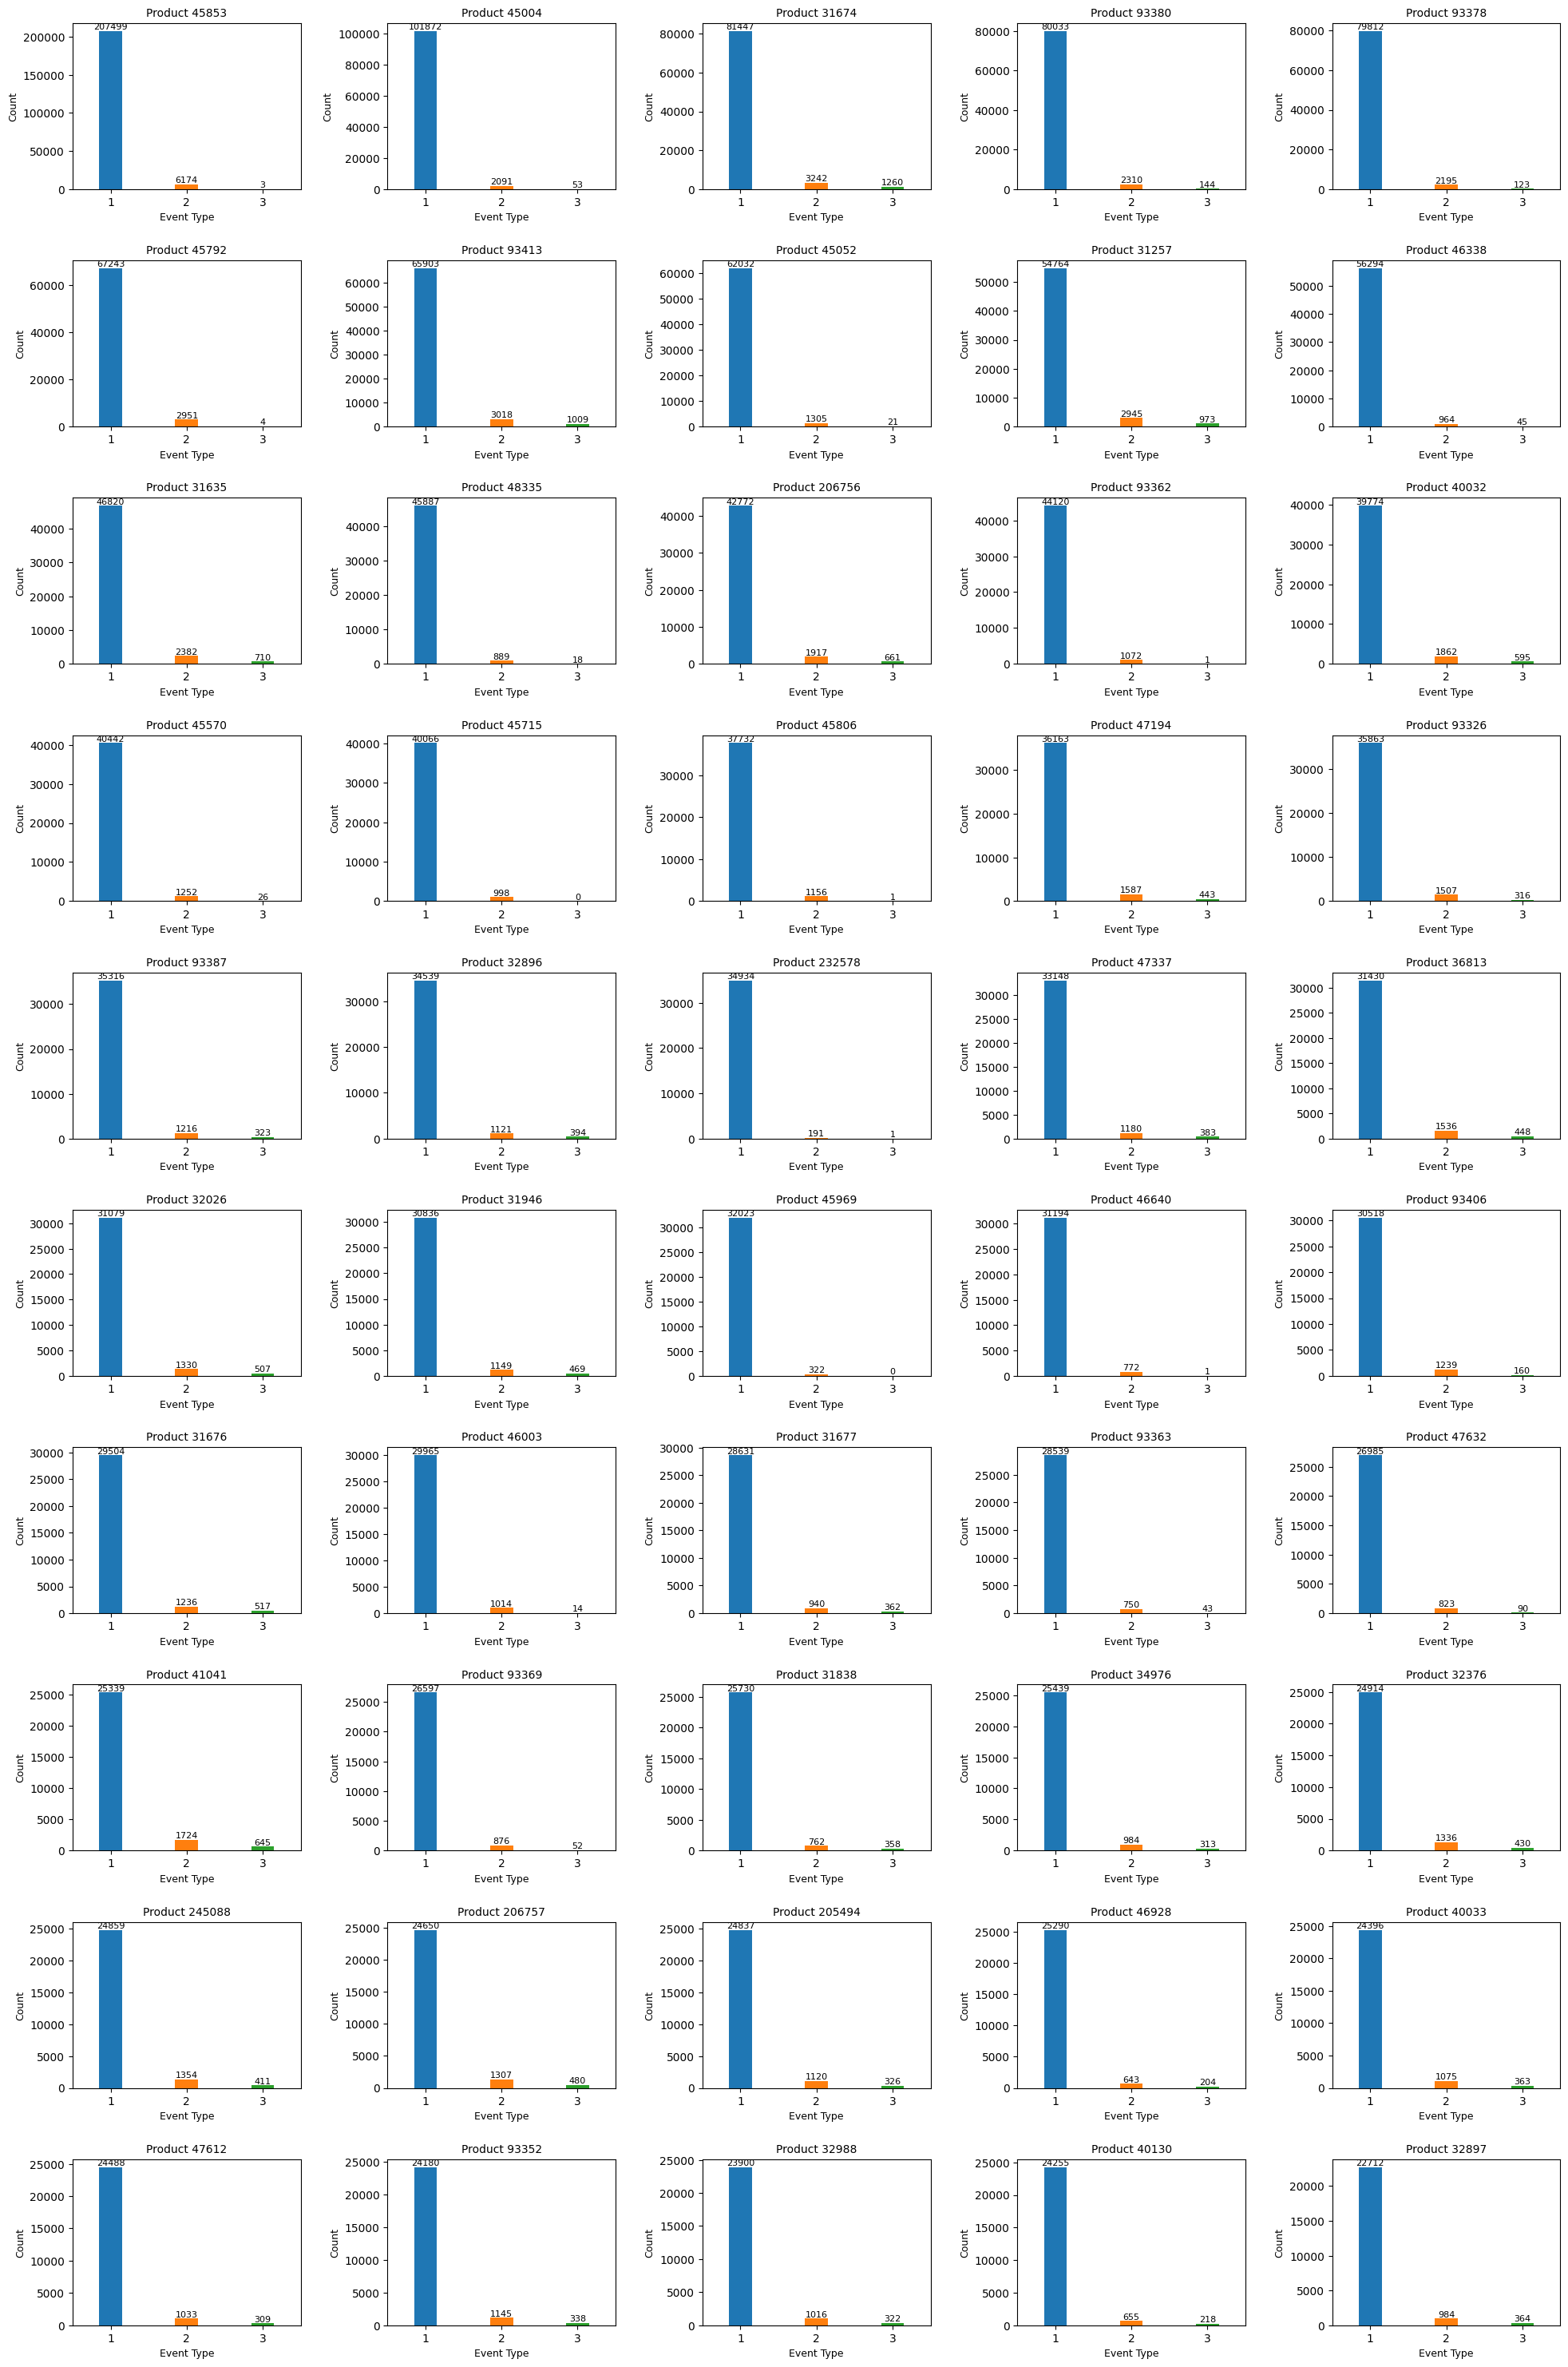

In [28]:
# 제품 빈도 계산
product_counts = df.group_by('product_id_index').agg(
    pl.count('product_id_index').alias('count')
)

# 상위 50개 제품 선택
top_50_products = product_counts.sort('count', descending=True).head(50)

# 상위 50개 제품의 데이터를 필터링
filtered_df = df.filter(pl.col('product_id_index').is_in(top_50_products['product_id_index']))

# 각 product_id별 event_type_index 개수 계산
event_type_counts = filtered_df.group_by(['product_id_index', 'event_type_index']).agg(
    pl.count('event_type_index').alias('count')
)

# 제품 ID와 이벤트 타입 인덱스 가져오기
product_ids = top_50_products['product_id_index'].to_numpy()
event_types = np.array([1, 2, 3])

# 색상 설정
colors = ['tab:blue', 'tab:orange', 'tab:green']  # 기본 색상 사용

# 플롯 설정
fig, axes = plt.subplots(10, 5, figsize=(20, 30))
axes = axes.flatten()

for idx, product_id in enumerate(product_ids):
    ax = axes[idx]
    
    values = []
    for event_type in event_types:
        count = event_type_counts.filter(
            (pl.col('product_id_index') == product_id) & 
            (pl.col('event_type_index') == event_type)
        )['count'].to_numpy()
        
        if len(count) > 0:
            values.append(count[0])
        else:
            values.append(0)

    bars = ax.bar(event_types, values, color=colors, width=0.3)  # 색상 및 너비 조정
    ax.set_title(f"Product {product_id}", fontsize=10)
    ax.set_xlabel('Event Type', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.set_xticks(event_types)
    ax.set_xlim(0.5, 3.5)

    # 막대 위에 개수 표시
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom', fontsize=8)

plt.tight_layout(pad=2.0)
plt.show()

## **7. `user_session_index` 파악**

### 세션별 view2purchase

- 13,120개

In [29]:
# 데이터 정렬
sorted_df = df.sort(['user_session_index', 'product_id_index', 'event_time_index'])

# 이전 이벤트를 포함한 데이터 생성
sorted_df = sorted_df.with_columns(
    [pl.col('event_type_index').shift(1).alias('prev_event_type_index'),
     pl.col('event_time_index').shift(1).alias('prev_event_time_index')]
)

# view2purchase 필터링
view2purchase_df = sorted_df.filter(
    (pl.col('prev_event_type_index') == 1) & 
    (pl.col('event_type_index') == 3) & 
    (pl.col('product_id_index') == pl.col('product_id_index').shift(1)) & 
    (pl.col('user_session_index') == pl.col('user_session_index').shift(1))
)

# 결과 출력
view2purchase_df.select(['user_session_index', 'user_id_index', 'product_id_index', 
                         'prev_event_time_index', 'event_time_index'])

user_session_index,user_id_index,product_id_index,prev_event_time_index,event_time_index
u32,u32,u32,u32,u32
4747,228620,93319,1572273481,1572273759
5615,1565676,32896,1571071980,1571072054
9944,4215560,31257,1570685253,1570685337
16489,2819615,36977,1573985633,1573985877
23137,1779079,46777,1571230604,1571230649
32704,4687417,46928,1573978479,1573978574
34309,3535304,31674,1571047926,1571048113
38666,5505178,31702,1574318631,1574318646
47575,495585,30492,1572428777,1572428808


### 세션별 view2cart2purchase

In [35]:
# tqdm 설정
tqdm.pandas()

# 데이터프레임을 pandas로 변환
df_pd = df.to_pandas()

# 데이터 정렬
sorted_df = df_pd.sort_values(['user_session_index', 'product_id_index', 'event_time_index'])

# 전환 확인 함수
def check_transition(group):
    found_view = False
    found_cart = False
    for event_type in group['event_type_index']:
        if event_type == 1:
            found_view = True
            fount_cart = False
        elif event_type == 2 and found_view:
            found_cart = True
        elif event_type == 3 and found_cart:
            return True
    return False

# 각 세션과 제품에 대해 순차적으로 전환을 확인
transition_flags = sorted_df.groupby(['user_session_index', 'product_id_index']).progress_apply(check_transition)

# 전환이 발생한 세션과 제품 필터링
transition_indices = transition_flags[transition_flags].index

# 원본 데이터에서 해당하는 행 필터링
transition_df = sorted_df.set_index(['user_session_index', 'product_id_index']).loc[transition_indices].reset_index()

# 원하는 열 출력
result_df = transition_df[['user_session_index', 'user_id_index', 'product_id_index']]

# 데이터 타입 변환
result_df.loc[:, 'user_session_index'] = result_df['user_session_index'].astype(int)

result_df

,user_session_index,user_id_index,product_id_index
0,705.0,10657038,36947
1,705.0,10657038,36947
2,705.0,10657038,36947
3,705.0,10657038,36947
4,705.0,10657038,36947
...,...,...,...
499740,89688249.0,5986635,33025
499741,89688249.0,5986635,33025
499742,89691958.0,2032861,36633
499743,89691958.0,2032861,36633


### 유저별 view2purchase

In [9]:
# 데이터 정렬
sorted_df = df.sort(['user_id_index', 'product_id_index', 'event_time_index'])

# 이전 이벤트를 포함한 데이터 생성
sorted_df = sorted_df.with_columns(
    [pl.col('event_type_index').shift(1).alias('prev_event_type_index'),
     pl.col('event_time_index').shift(1).alias('prev_event_time_index'),
     pl.col('user_id_index').shift(1).alias('prev_user_id_index')]
)

# view2purchase 필터링
view2purchase_df = sorted_df.filter(
    (pl.col('prev_event_type_index') == 1) & 
    (pl.col('event_type_index') == 3) & 
    (pl.col('product_id_index') == pl.col('product_id_index').shift(1)) & 
    (pl.col('user_id_index') == pl.col('prev_user_id_index'))
)

# 결과 출력
result = view2purchase_df.select(['user_id_index', 'product_id_index', 'prev_event_time_index', 'event_time_index'])

result

user_id_index,product_id_index,prev_event_time_index,event_time_index
u32,u32,u32,u32
25188,32247,1570598951,1570599567
25188,32350,1571579280,1571579607
46649,109734,1573104267,1573104353
46649,109734,1573104378,1573104414
46649,109765,1573103577,1573103976
46649,109765,1573104023,1573104113
82780,47840,1571493423,1571493495
89636,32025,1573021441,1573021888
89636,32026,1570768600,1570768641
